# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1.** Problem Statement
In 2-4 sentences, explain the kind of problem you want to look at and the datasets you will be wrangling for this project.

Finding the right datasets can be time-consuming. Here we provide you with a list of websites to start with. But we encourage you to explore more websites and find the data that interests you.

Google Dataset Search https://datasetsearch.research.google.com/
The U.S. Government’s open data https://data.gov/
UCI Machine Learning Repository https://archive.ics.uci.edu/ml/index.php

This project analyzes renewable energy consumption and production across the United States, with a focus on heating degree days (HDDs) as an indicator of heating demand. The initial goal was to explore correlations between HDDs and renewable energy usage, but a lack of significant relationships prompted a shift in focus. The revised research question investigates whether machine learning can model the relationship between renewable energy production and consumption at the national level and uncover state-level variations. By clustering states based on production-consumption patterns, the project aims to identify regional differences in renewable energy resilience.

### **1.2.** Gather at least two datasets using two different data gathering methods

List of data gathering methods:

- Download data manually
- Programmatically downloading files
- Gather data by accessing APIs
- Gather and extract data from HTML files using BeautifulSoup
- Extract data from a SQL database

Each dataset must have at least two variables, and have greater than 500 data samples within each dataset.

For each dataset, briefly describe why you picked the dataset and the gathering method (2-3 full sentences), including the names and significance of the variables in the dataset. Show your work (e.g., if using an API to download the data, please include a snippet of your code). 

Load the dataset programmtically into this notebook.

#### **Dataset 1**

Type: national_renewable_energy_data.csv, CSV File

Method: The data was gathered using the API gathering method from eia.gov.
I chose this dataset because it provides a complete renewable energy usage and production record across the United States which I could break down to State-level. Among the energy usage sectors, I chose to focus on the residential sector because I am interested in how renewable energies may supply home heating demands.

Dataset variables:

*   *Variable 1 period: year)
*   *Variable 2 seriesId: code for renewable energy data
*   *Variable 3 seriesDescription: seriesId code spelled out)
*   *Variable 4 stateId: state code
*   *Variable 5 stateDescription: state name
*   *Variable 6 value: energy data value
*   *Variable 7 unit: unit of energy value

**Note:** This notebook retrieves the API key from environment variables set locally on the system. Ensure you have set the EIA_API_KEY variable in your environment before running this notebook

In [1]:
import os

# Retrieve the API key from the environment
api_key = os.getenv("EIA_API_KEY")

# Ensure the API key is retrieved
if api_key:
    print("API key loaded successfully (hidden from output).")
else:
    print("API key not found. Ensure it's set in your environment.")

API key loaded successfully (hidden from output).


In [2]:
import requests
import pandas as pd
import os

# Get the API key from environment variables
api_key = os.getenv("EIA_API_KEY")  # Ensure your API key is stored correctly

# Construct the request URL with the API key
url = f"https://api.eia.gov/v2/seds/data/?frequency=annual&data[0]=value&facets[seriesId][]=REPRB&facets[seriesId][]=RERCB&facets[seriesId][]=RETCB&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000&api_key={api_key}"

# Fetch the data
response = requests.get(url)

# Check the response status
if response.status_code == 200:
    data = response.json()
    if "response" in data and "data" in data["response"]:
        df_re = pd.DataFrame(data["response"]["data"])
        print(df_re.head())  # Display the first few rows
    else:
        print("No data found in response.")
else:
    print(f"Error {response.status_code}: {response.reason}")

  period seriesId                                  seriesDescription stateId  \
0   2022    RETCB                 Renewable energy total consumption      VA   
1   2022    RETCB                 Renewable energy total consumption      UT   
2   2022    RETCB                 Renewable energy total consumption      US   
3   2022    RETCB                 Renewable energy total consumption      TX   
4   2022    RERCB  Renewable energy sources consumed by the resid...      SC   

  stateDescription    value         unit  
0         Virginia   165465  Billion Btu  
1             Utah    36708  Billion Btu  
2    United States  8090779  Billion Btu  
3            Texas   742759  Billion Btu  
4   South Carolina     3248  Billion Btu  


In [3]:
#Optional: store the raw data in your local data store
# Save the raw Energy dataset to a CSV file
df_re.to_csv("national_renewable_energy_data.csv", index=False)

#### Dataset 2

Type: SEDS.txt, TEXT File

Method: The data was gathered downloading a bulk data file from https://www.eia.gov/opendata/index.php#bulk-downloads)


I chose this Heating Degree Day dataset because it provided "more data in one place" than was available from NOAA, for example, and would have required downloading state data year to year. This set contains state-level HDD observations from 1960 to 2023, which exceeds the date range of the energy data it will be compared to.

Dataset variables:

*   *Variable 1 series_id: data code
*   *Variable 2 name: descriptive name for data and location	
*   *Variable 2 geography: code for location
*   *Variable 2 year: year of observation
*   *Variable 2 value: hdd data value in days

In [4]:
import json
import pandas as pd

# File path
file_path = "/Users/dario/Desktop/Udacity/3. Advanced Data Wrangling/Project/Renewables/EIAdownloads/SEDS.txt"

# Initialize an empty list to store HDD data
hdd_data = []

# Open and process the file line-by-line
with open(file_path, "r") as file:
    for line in file:
        try:
            # Parse each line as a JSON object
            json_obj = json.loads(line.strip())
            
            # Check if the series_id is related to HDD (contains ZWHDP)
            if "ZWHDP" in json_obj.get("series_id", ""):
                series_id = json_obj.get("series_id")
                name = json_obj.get("name", "Unknown")
                geography = json_obj.get("geography", "Unknown")
                data_points = json_obj.get("data", [])
                
                # Flatten the data points and add series info
                for year, value in data_points:
                    hdd_data.append({
                        "series_id": series_id,
                        "name": name,
                        "geography": geography,
                        "year": year,
                        "value": value
                    })
        except json.JSONDecodeError:
            print("Skipping invalid JSON line.")

# Convert the extracted data to a DataFrame
df_hdd = pd.DataFrame(hdd_data)

# Inspect the DataFrame
print(df_hdd.head())

Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSON line.
Skipping invalid JSO

         series_id                                       name geography  year  \
0  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2023   
1  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2022   
2  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2021   
3  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2020   
4  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2019   

   value  
0   2156  
1   2502  
2   2373  
3   2164  
4   2336  


In [5]:
df_hdd.tail(5)

,series_id,name,geography,year,value
3323,SEDS.ZWHDP.NY.A,"Heating degree days (HDD), New York",USA-NY,1964,6355
3324,SEDS.ZWHDP.NY.A,"Heating degree days (HDD), New York",USA-NY,1963,6788
3325,SEDS.ZWHDP.NY.A,"Heating degree days (HDD), New York",USA-NY,1962,6821
3326,SEDS.ZWHDP.NY.A,"Heating degree days (HDD), New York",USA-NY,1961,6549
3327,SEDS.ZWHDP.NY.A,"Heating degree days (HDD), New York",USA-NY,1960,6551


Optional data storing step: You may save your raw dataset files to the local data store before moving to the next step.

In [6]:
#Optional: store the raw data in your local data store
# Save the raw HDD dataset to a CSV file
df_hdd.to_csv("hdd_data.csv", index=False)

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

### 2a Assess Renewable Energy Data

In [7]:
#For both Quality and Tidiness Issues - Inspecting the dataframe visually
print(df_re.head()) #view the df -check tail and sample too
print(df_re.info()) #view data type
print(df_re.describe()) #inspect data statistically

  period seriesId                                  seriesDescription stateId  \
0   2022    RETCB                 Renewable energy total consumption      VA   
1   2022    RETCB                 Renewable energy total consumption      UT   
2   2022    RETCB                 Renewable energy total consumption      US   
3   2022    RETCB                 Renewable energy total consumption      TX   
4   2022    RERCB  Renewable energy sources consumed by the resid...      SC   

  stateDescription    value         unit  
0         Virginia   165465  Billion Btu  
1             Utah    36708  Billion Btu  
2    United States  8090779  Billion Btu  
3            Texas   742759  Billion Btu  
4   South Carolina     3248  Billion Btu  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   period             5000 non-null   object
 1   seriesId 

There are 5000 entries; data are for renewable energy production and consumption by State as expected; all entries are strings; there are three unique entries corresponding to the Energy data type (total production, total consumption, residential consumption); 52 State-entries are present; The top renewable energy producer is California.

In [8]:
#For both Quality and Tidiness Issues - Inspecting the dataframe programmatically
print(df_re.isnull().sum()) #check/count missing values per column
print(df_re['unit'].unique()) #check for inconsistencies with units
assert df_re['unit'].nunique() == 1, "Unexpected unit inconsistencies found!" #validate that all units are consistent

period               0
seriesId             0
seriesDescription    0
stateId              0
stateDescription     0
value                0
unit                 0
dtype: int64
['Billion Btu']


There are no missing values and the measurement units are consistent, including after asserting a statement. Note, however, that after necessary pivoting of the dataframe some null values will appear.

In [9]:
#check for duplicates
duplicates = df_re[df_re.duplicated(subset=['period', 'stateId', 'seriesId', 'value'], keep=False)]
print(duplicates)

Empty DataFrame
Columns: [period, seriesId, seriesDescription, stateId, stateDescription, value, unit]
Index: []


Searching for duplicates in a subset containing period, stateId and seriesId returns no duplicates, so we now that same period, state, or series entries are not duplicated.

### Quality Issue(s) 1:
All columns are stored as objects, which is inefficient for numeric data.  
The Period variable needs converting to DateTime, seriesId to category, and value to integer to ensure numeric operations and that visualizations work correctly.

It is not apparent yet, but after pivoting the dataframe to resolve the tidiness issue below, null values will be introduced into the dataframe.

It will become obvious that there is a data-outlier problem.

### Tidiness Issue 1:
Multiple Observations in One Column:
The seriesId column combines distinct variables: “renewabale energy production”, “renewable energy total consumption”, "renewable energy residential consumption"

## 3. Clean data
Clean the data to solve the 4 issues corresponding to data quality and tidiness found in the assessing step. Make sure you include justifications for your cleaning decisions.

After the cleaning for each issue, please use either the visually or programatical method to validate the cleaning was succesful.

At this stage, you are also expected to remove variables that are unnecessary for your analysis and combine your datasets. Depending on your datasets, you may choose to perform variable combination and elimination before or after the cleaning stage. Your dataset must have at least 4 variables after combining the data.

**Note:**
In this notebook I will asses the issues and clean them in order for each dataset, instead of first assessing all issues by dataset, and then cleaning them together at the end. This makes more sense to me as it ensures a better progression of the project.

### 3a Cleaning Renawable Energy data

In [10]:
# Quality (Tidy, really): make value an integer
df_re_clean = df_re.copy()
df_re_clean['value'] = pd.to_numeric(df_re_clean['value'], errors='coerce')
df_re_clean['value'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: value
Non-Null Count  Dtype
--------------  -----
5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


The value entries have been converted to numeric values (integer), which alows for numeric operations and plotting.

In [11]:
# Tidy: Make seriesId a category
df_re_clean['seriesId'] = df_re_clean['seriesId'].astype('category')
df_re_clean['seriesId'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: seriesId
Non-Null Count  Dtype   
--------------  -----   
5000 non-null   category
dtypes: category(1)
memory usage: 5.1 KB


SeriesId has been turned into a category which allows for certain analyses, like plotting data by category (see box and whiskers plots below)

In [12]:
# Tidy: unstack data, make period a date
df_re_clean['period'] = pd.to_datetime(df_re_clean['period'], format='%Y').dt.year
df_re_clean['period'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5000 entries, 0 to 4999
Series name: period
Non-Null Count  Dtype
--------------  -----
5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


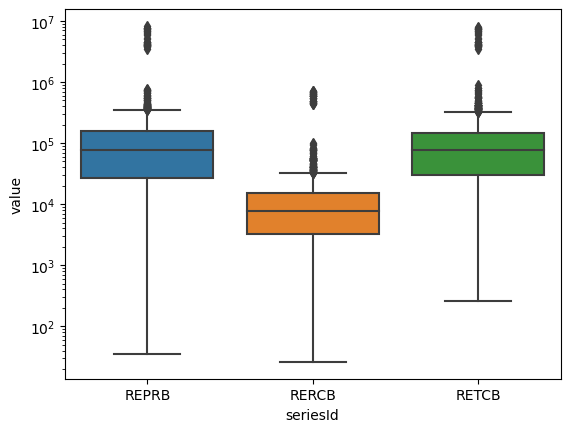

In [13]:
# Quality issue: search for outliers among States
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='seriesId', y='value', data=df_re_clean)
plt.yscale('log')  # Use a log scale if values vary widely
plt.show()

#### Observation
Viewing the data on a box and whiskers plot, it appears that for the three data types under investigation there is a distinct group of outliers with much larger values than the rest of the data (note the logarythmic scale). These need to be investigated more systematically as a quality issue and dealt with (eliminated) accordingly.

In [14]:
# Programmatically flagging States with outlier data
# Calculate IQR for each seriesId
for series in df_re_clean['seriesId'].unique():
    subset = df_re_clean[df_re_clean['seriesId'] == series]
    Q1 = subset['value'].quantile(0.25)
    Q3 = subset['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Flag outliers
    df_re_clean.loc[df_re_clean['seriesId'] == series, 'Outlier'] = (
        (subset['value'] < lower_bound) | (subset['value'] > upper_bound)
    )

In [15]:
# Filter for comparable States
#Create a subset of the data that excludes the outliers:
comparable_states = df_re_clean[df_re_clean['Outlier'] == False]
comparable_states.shape

(4653, 8)

4653 rows have been identified as "comparamble" meaning that 347 (5000-4653) contain outliers

In [16]:
# Validate the cleaning
# Compare before and after cleaning to demonstrate the effect of removing outliers:
print(df_re_clean['value'].describe())  # Before cleaning
print(comparable_states['value'].describe())  # After cleaning

count    5.000000e+03
mean     1.453482e+05
std      6.296462e+05
min      2.600000e+01
25%      9.051500e+03
50%      3.315500e+04
75%      1.080248e+05
max      8.307342e+06
Name: value, dtype: float64
count      4653.000000
mean      61865.724909
std       72247.909021
min          26.000000
25%        8304.000000
50%       27606.000000
75%       96417.000000
max      347175.000000
Name: value, dtype: float64


In [17]:
# Identify and display the excluded states:

# Filter the original DataFrame to only include outliers
outlier_states = df_re_clean[df_re_clean['Outlier'] == True]

# View the unique states that were identified
outlier_states_list = outlier_states['stateId'].unique()
print("States identified as outliers:", outlier_states_list)

# Save the outlier states for documentation
outlier_states.to_csv("re_outlier_states.csv", index=False)

States identified as outliers: ['US' 'TX' 'IA' 'NY' 'CA' 'FL' 'WA' 'PA' 'MI' 'OH' 'IL']


#### Observation:
It appears that a number of states contain outliers for a total of 347 yearly entries. However, what elimination of these entries does is uncertain yet: "describing" the data before and after yields different statistics for sure, but it is unclear whether removing them is for the better. 

Importantly, when printing out the list of states with outliers, one state is labelled "US", which I had missed when visually inspecting the whole dataset.

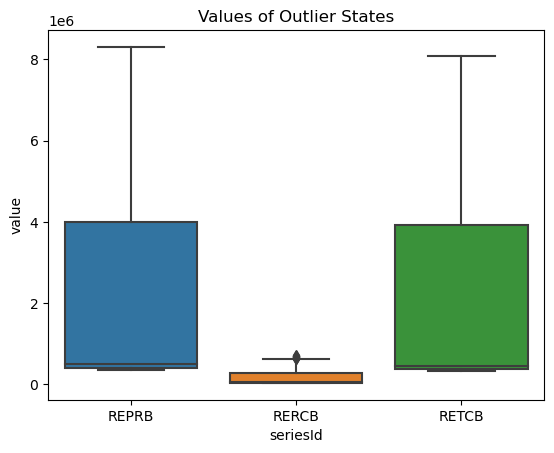

In [18]:
# Plot outlier states
sns.boxplot(x='seriesId', y='value', data=outlier_states)
plt.title("Values of Outlier States")
plt.show()

A box and whiskers plot of the outlier states displays similar range to the outlier data identified in the previous plot.

In [19]:
# Quantify the number of states before and after cleaning
print("Total states before cleaning:", df_re_clean['stateId'].nunique())
print("Total states after cleaning:", comparable_states['stateId'].nunique())

Total states before cleaning: 52
Total states after cleaning: 51


#### Observation:
While there were 52 states to begin with, which is one more than the 50 states of the union plus the District of Columbia, and a number of states were flagged as outliers and eliminated as such, the count of states only went down by one. While this "corrects" the number of expected states + DC, I would have expected fewer states after cleaning.

In [20]:
# States with both outlier and non-outlier data
mixed_states = df_re_clean[df_re_clean['stateId'].isin(outlier_states_list)]['stateId'].value_counts()
print("States with some valid and some outlier data:", mixed_states)

States with some valid and some outlier data: CA    97
US    96
TX    96
PA    96
IL    96
IA    96
OH    96
NY    96
WA    96
MI    96
FL    96
Name: stateId, dtype: int64


#### Observation:
Expressly searching for states that have both valid entries and outliers, it seems that the problem arises because some states have outliers some years (rows), but not necessarily throughout the entire series. Below, I will search for the only state that consistently return outliers.

In [21]:
# Identify and eliminate State where all rows are outliers

# Count total rows per stateId in the full dataset
state_total_counts = df_re_clean['stateId'].value_counts()

# Count outlier rows per stateId
outlier_counts = outlier_states['stateId'].value_counts()

# Align the two Series to have the same index
aligned_outlier_counts = outlier_counts.reindex(state_total_counts.index, fill_value=0)

# Identify state where all rows are outliers to be excluded
excluded_state = state_total_counts[aligned_outlier_counts == state_total_counts].index
print("State eliminated entirely:", list(excluded_state))

State eliminated entirely: ['US']


#### Observation:
It appears that the only state that has outliers in each row is labelled "US", meaning that on top of the individual states (therefore only 51 states listed, if 52 was the total), there is also a compoundend US entry that I had missed when inspecting the file visually. The compounded US entry should not have been listed as "stateId" and should instead have been a variable in it's self. Thi effectively **constitutes a duplicate AND an outlier** that skews the data. I consider this a **Data Quality issue**, au pair as missing values, since the national count should not be listed as an individual state.

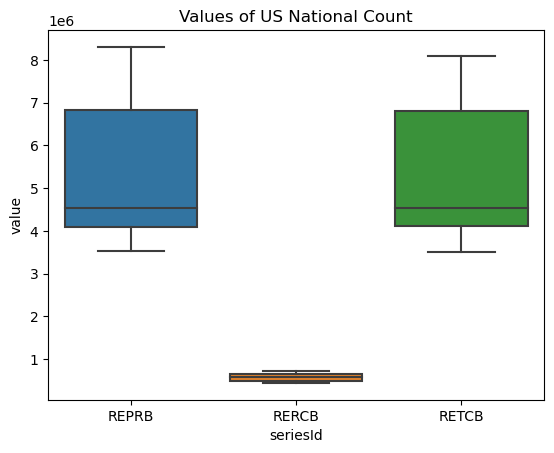

In [22]:
# Plot compounded US data

# Filter rows corresponding to the national count (listed as excluded_state)
excluded_state = df_re_clean[df_re_clean['stateId'].isin(excluded_state)]

# Plot the values of entirely removed states
sns.boxplot(x='seriesId', y='value', data=excluded_state)
plt.title("Values of US National Count")
plt.show()

Plotting US data alone, they comprize the same value ranges as the outlier data previously identified and need to be eliminated as such (**Quality issue**).
"US" does not align with the scope of the project, which is to compare states.

In [23]:
# Remove 'US' from the dataset
df_re_states = df_re_clean[df_re_clean['stateId'] != 'US']
print("US entry removed from the dataset.")

US entry removed from the dataset.


In [24]:
# Check if 'US' exists in the stateId column
print("Unique stateIds in df_re_states:")
print(df_re_states['stateId'].unique())

# Check specifically for 'USA'
if 'US' in df_re_states['stateId'].unique():
    print("Warning: 'USA' still exists in the data!")
else:
    print("'US' has been successfully removed.")

Unique stateIds in df_re_states:
['VA' 'UT' 'TX' 'SC' 'NH' 'NE' 'ND' 'AZ' 'AR' 'AL' 'AK' 'RI' 'PA' 'OR'
 'MD' 'MA' 'LA' 'KY' 'NC' 'TN' 'SD' 'OK' 'MT' 'MS' 'MO' 'IN' 'IL' 'ID'
 'IA' 'WY' 'WV' 'WI' 'OH' 'NY' 'NV' 'KS' 'CA' 'MN' 'WA' 'NM' 'MI' 'ME'
 'HI' 'GA' 'FL' 'DE' 'VT' 'NJ' 'DC' 'CT' 'CO']
'US' has been successfully removed.


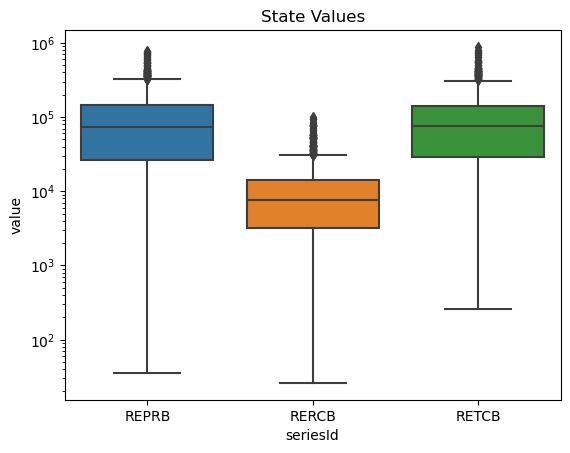

In [25]:
# Observe effect of removing US-national to individual state data

sns.boxplot(x='seriesId', y='value', data=df_re_states)
plt.yscale('log')  # Use a log scale if values vary widely
plt.title("State Values")
plt.show()

After removing US aggregate data, no more outliers are present.

In [26]:
df_re_states.head(5)

,period,seriesId,seriesDescription,stateId,stateDescription,value,unit,Outlier
0,2022,RETCB,Renewable energy total consumption,VA,Virginia,165465,Billion Btu,False
1,2022,RETCB,Renewable energy total consumption,UT,Utah,36708,Billion Btu,False
3,2022,RETCB,Renewable energy total consumption,TX,Texas,742759,Billion Btu,True
4,2022,RERCB,Renewable energy sources consumed by the resid...,SC,South Carolina,3248,Billion Btu,False
5,2022,RETCB,Renewable energy total consumption,NH,New Hampshire,39952,Billion Btu,False


The dataset has now be cleaned to a point where other tidiness issues may be addressed.

In [27]:
# Further cleaning
# Drop unnecessary columns
columns_to_drop = ['seriesDescription','stateDescription', 'unit', 'Outlier']
df_re_states = df_re_states.drop(columns=columns_to_drop)
# Rename the 'value' column to 'BBtu' and 'period' to 'year'
df_re_states = df_re_states.rename(columns={"value": "BBtu", "period": "year"})

# Verify the result
print(df_re_states.head())

   year seriesId stateId    BBtu
0  2022    RETCB      VA  165465
1  2022    RETCB      UT   36708
3  2022    RETCB      TX  742759
4  2022    RERCB      SC    3248
5  2022    RETCB      NH   39952


In [28]:
# Pivot the data to restructure it, so that each column contains a variable
# Pivot the dataframe
df_re_states_clean = df_re_states.pivot(index=['year', 'stateId'], columns='seriesId', values='BBtu')

# Reset the index to make 'period' and 'stateId' regular columns
df_re_states_clean = df_re_states_clean.reset_index()

# Verify the result
print(df_re_states_clean.head())

seriesId  year stateId     REPRB  RERCB     RETCB
0         1990      AZ   42902.0    NaN       NaN
1         1990      CA  379479.0    NaN       NaN
2         1990      CO   16476.0    NaN       NaN
3         1990      MT       NaN    NaN   48460.0
4         1990      NC       NaN    NaN  121053.0


#### Observation:
After pivotiong the dataframe a couple of things become obvious: there was no need to rename the value column to BBtu, and more importantly that Null values were introduced because for certain states there aren't specific yearly entries for some REPRB, RERCB or RETCB variables. Additionally, while the dataframe has a name, after pivoting the columns appear to have been given the "seriesId" name, which is displayet at the top of the index column.

In [29]:
# Remove the 'seriesId' metadata from the column index
df_re_states_clean.columns.name = None

# Verify the result
print(df_re_states_clean.columns)

Index(['year', 'stateId', 'REPRB', 'RERCB', 'RETCB'], dtype='object')


In [30]:
print(df_re_states_clean.head())

   year stateId     REPRB  RERCB     RETCB
0  1990      AZ   42902.0    NaN       NaN
1  1990      CA  379479.0    NaN       NaN
2  1990      CO   16476.0    NaN       NaN
3  1990      MT       NaN    NaN   48460.0
4  1990      NC       NaN    NaN  121053.0


In [31]:
df_re_states_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639 entries, 0 to 1638
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     1639 non-null   int64  
 1   stateId  1639 non-null   object 
 2   REPRB    1636 non-null   float64
 3   RERCB    1632 non-null   float64
 4   RETCB    1636 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 64.2+ KB


The cleaned dataframe appears to be in order, NaNs apart

In [32]:
#Check the number of NaN values per column
missing_per_column = df_re_states_clean.isnull().sum()
print(missing_per_column)

year       0
stateId    0
REPRB      3
RERCB      7
RETCB      3
dtype: int64


In [33]:
# Check the number of NaN values per row
missing_per_row = df_re_states_clean.isnull().sum(axis=1)
print(missing_per_row.value_counts())  # Distribution of rows with missing values

0    1632
2       6
1       1
dtype: int64


There are 1632 rows with 0 missing values and 8 rows with 2 missing values each.

In [34]:
missing_rows = df_re_states_clean[df_re_states_clean.isnull().sum(axis=1) > 0]
print(missing_rows)

   year stateId     REPRB  RERCB     RETCB
0  1990      AZ   42902.0    NaN       NaN
1  1990      CA  379479.0    NaN       NaN
2  1990      CO   16476.0    NaN       NaN
3  1990      MT       NaN    NaN   48460.0
4  1990      NC       NaN    NaN  121053.0
5  1990      ND   10208.0    NaN    9193.0
6  1990      NE       NaN    NaN   11735.0


It appears that there aren't many missing values (16 in total), all in the first year of the series and for 8 states.

Being for the first year, the missing values cannot be imputed due to lack of adjacent data, nor it makes particular sense to replace them with zero or dropping those rows. Instead, it warrants leaving the missing values and those data for the first year will not be included in analyses. The missing data will not affect the scope of the evaluation

The Renewable Energy dataframe is ready for analysis

In [35]:
# Save the cleaned renewable energy state dataset to a CSV file
df_re_states_clean.to_csv("re_clean_state_data.csv", index=False)

### 2b Assess Heating Degrees Day Data

### Quality Issue(s) 2:
Identified data-quality issues are: 
- year column stored as string; 
- the dates range from 1960 to 2023 which is larger than for the Energy data;
- not all states have data for every useful years, which limits the scope of the analysis for certain states;
- importantly, this dataset also contains a national aggregate entry mixed in with the states, which constitutes replicated data which will necessarily affect the distribution of data.


In [36]:
#For both Quality and Tidiness Issues - Inspecting the dataframe visually
print(df_hdd.head()) #view the df -check tail and sample too
print(df_hdd.info()) #view data type
print(df_hdd.describe()) #inspect data statistically

         series_id                                       name geography  year  \
0  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2023   
1  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2022   
2  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2021   
3  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2020   
4  SEDS.ZWHDP.SC.A  Heating degree days (HDD), South Carolina    USA-SC  2019   

   value  
0   2156  
1   2502  
2   2373  
3   2164  
4   2336  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   series_id  3328 non-null   object
 1   name       3328 non-null   object
 2   geography  3328 non-null   object
 3   year       3328 non-null   object
 4   value      3328 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 130.1+ KB
None
           

#### Data quality issues:
From assessing the data visualy it apperas that the year column is stored as string instead of DateTime, which creates problems for analysis. 
Dates range from 1960 to 2023, which is larger than the renewable energy dataframe, so data must be trimmed accordingly. 
Furthermore, not all states have data for every year in the series, which limits the scope of the analysis for some states.

Other than the datatype issue, the mismatch in age ranges is a completeness issue which introduces inconsistent temporal coverage, resulting in NaN values for the missing data in one dataset. These data must be either filtered out or kept in order to try projecting renewable energy data over the broader temporal range present in the HDD data. However, they cannot be imputed as they occurr at the extremities of the data set.

Similarly to the Renewable Energy dataframe, here too outliers are present, or rather replicated data in the form of a national aggregate entry which must be isolated and removed.    

In [37]:
#For both Quality and Tidiness Issues - Inspecting the dataframe programmatically
print(df_hdd.isnull().count()) #check/count missing values
print(df_hdd['name'].unique()) #check for inconsistencies with states (national aggregates?)

series_id    3328
name         3328
geography    3328
year         3328
value        3328
dtype: int64
['Heating degree days (HDD), South Carolina'
 'Heating degree days (HDD), South Dakota'
 'Heating degree days (HDD), Alaska' 'Heating degree days (HDD), Alabama'
 'Heating degree days (HDD), Arkansas'
 'Heating degree days (HDD), Arizona'
 'Heating degree days (HDD), California'
 'Heating degree days (HDD), Colorado'
 'Heating degree days (HDD), Connecticut'
 'Heating degree days (HDD), Tennessee' 'Heating degree days (HDD), Texas'
 'Heating degree days (HDD), United States'
 'Heating degree days (HDD), Utah' 'Heating degree days (HDD), Virginia'
 'Heating degree days (HDD), Vermont'
 'Heating degree days (HDD), Washington'
 'Heating degree days (HDD), District of Columbia'
 'Heating degree days (HDD), Delaware'
 'Heating degree days (HDD), Florida' 'Heating degree days (HDD), Georgia'
 'Heating degree days (HDD), Hawaii' 'Heating degree days (HDD), Iowa'
 'Heating degree days (HDD), 

There are no missing values, however, as suspected, a national aggregate is present here to, with name listed as United States, which will skew the state-data distribution. It will therefore need to be dealt with as a **data quality issue**.

In [38]:
#programmatically check for duplicates
duplicates = df_hdd[df_hdd.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [series_id, name, geography, year, value]
Index: []


There are no duplicates in this dataframe.

In [39]:
#programmatically check for outliers
outliers = df_hdd[(df_hdd["value"] == 0) | (df_hdd["value"] > 10000)]
print(outliers)

            series_id                                     name geography  \
128   SEDS.ZWHDP.AK.A        Heating degree days (HDD), Alaska    USA-AK   
129   SEDS.ZWHDP.AK.A        Heating degree days (HDD), Alaska    USA-AK   
130   SEDS.ZWHDP.AK.A        Heating degree days (HDD), Alaska    USA-AK   
131   SEDS.ZWHDP.AK.A        Heating degree days (HDD), Alaska    USA-AK   
134   SEDS.ZWHDP.AK.A        Heating degree days (HDD), Alaska    USA-AK   
...               ...                                      ...       ...   
2925  SEDS.ZWHDP.ND.A  Heating degree days (HDD), North Dakota    USA-ND   
2931  SEDS.ZWHDP.ND.A  Heating degree days (HDD), North Dakota    USA-ND   
2933  SEDS.ZWHDP.ND.A  Heating degree days (HDD), North Dakota    USA-ND   
2937  SEDS.ZWHDP.ND.A  Heating degree days (HDD), North Dakota    USA-ND   
2938  SEDS.ZWHDP.ND.A  Heating degree days (HDD), North Dakota    USA-ND   

      year  value  
128   2023  10902  
129   2022  10035  
130   2021  10976  
131   2

Filtering data for values that are exactly 0 or above an arbitrary threshold of 10,000 days returns 116 rows of data which exceed this value. Adjusting the values "clarifies" that all zero-hdd values are from Hawaii, a tropical state for which zero-values may be expected, while more than one cold states comprize the upper value ranges (Alaska, North Dakota, etc.)

It therefore appears that no outliers are present, but in fact all data represent useful and truthful data entries.

### 3b Cleaning Heating Degree Day data

### Tidiness Issue 2: 
In the hdd dataframe, series_id names include the state code; there is a "name" column wich includes the state names, among other redundant information, while "geography" entries are composed of "US-" plus the state code. These need to be cleaned up in a way that is not redundant and matches with the renewable energy dataframe for merging.

In [40]:
# Quality: make value an integer, usable for analyses
df_hdd_clean = df_hdd.copy()
df_hdd_clean['value'] = pd.to_numeric(df_hdd_clean['value'], errors='coerce')
df_hdd_clean['value'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3328 entries, 0 to 3327
Series name: value
Non-Null Count  Dtype
--------------  -----
3328 non-null   int64
dtypes: int64(1)
memory usage: 26.1 KB


In [41]:
# Tidy: Make geography a category, useful for plotting
df_hdd_clean['geography'] = df_hdd_clean['geography'].astype('category')
df_hdd_clean['geography'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3328 entries, 0 to 3327
Series name: geography
Non-Null Count  Dtype   
--------------  -----   
3328 non-null   category
dtypes: category(1)
memory usage: 5.8 KB


In [42]:
# Tidy: unstack data, make period a date
df_hdd_clean['year'] = pd.to_datetime(df_hdd_clean['year'], format='%Y').dt.year
print(df_hdd_clean['year'])

0       2023
1       2022
2       2021
3       2020
4       2019
        ... 
3323    1964
3324    1963
3325    1962
3326    1961
3327    1960
Name: year, Length: 3328, dtype: int64


In [43]:
# Quality: Drop rows where year is 2023
df_hdd_clean = df_hdd_clean[df_hdd_clean['year'] != 2023]

# Check
print(df_hdd_clean['year'].unique())  # Check remaining years

[2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009
 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995
 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983 1982 1981
 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969 1968 1967
 1966 1965 1964 1963 1962 1961 1960]


For the time being I have decided to eliminate the 2023 year for which there is no corresponding renewable energy data, but I will keep the 1960-1989 data to see if I can backward project the existing energy data based on its correlation with hdd data.

In [44]:
print(df_hdd_clean['geography'].unique()) #check all "geography names"

['USA-SC', 'USA-SD', 'USA-AK', 'USA-AL', 'USA-AR', ..., 'USA-NH', 'USA-NJ', 'USA-NM', 'USA-NV', 'USA-NY']
Length: 52
Categories (52, object): ['USA', 'USA-AK', 'USA-AL', 'USA-AR', ..., 'USA-WA', 'USA-WI', 'USA-WV', 'USA-WY']


#### Observation
In this dataset also 52 states are present, which is one too many, already inculding DC. Here, however, the aggregated USA-USA enry was noticed when initially inspecting the dataframe visually.

In [45]:
# Tidy: stripping the geography name to include the state codes only to match renewable energy dataset
df_hdd_clean['geography'] = df_hdd_clean['geography'].str.replace('USA-', '', case=False)
print(df_hdd_clean['geography'].unique())

['SC' 'SD' 'AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'TN' 'TX' 'USA' 'UT' 'VA'
 'VT' 'WA' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID' 'WI' 'WV' 'WY' 'IL' 'IN'
 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC' 'OH' 'OK'
 'OR' 'PA' 'RI' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY']


After listing the state codes it appears that for these data too there is a compounded national value listed as USA, which will be dealt with in order to evaluate state data only.

In [46]:
# Tidy: cleaning further to be able to merge the datasets
# Drop 'series_id' and 'name' columns because they are of no use
df_hdd_clean = df_hdd_clean.drop(columns=['series_id', 'name'])

# Rename columns 'geography' to 'stateId' to match the Renewable Energy dataframe 
# and change 'value' to 'hdd' for usefulness
df_hdd_clean = df_hdd_clean.rename(columns={'geography': 'stateId', 'value': 'hdd'})

# Verify the changes
print(df_hdd_clean.head())

  stateId  year   hdd
1      SC  2022  2502
2      SC  2021  2373
3      SC  2020  2164
4      SC  2019  2336
5      SC  2018  2612


In [47]:
# Quality: programmatically separating National from State values
# Create a separate DataFrame for rows where stateId is 'USA'
df_hdd_usa = df_hdd_clean[df_hdd_clean['stateId'] == 'USA']

# Remove rows where stateId is 'USA' from df_hdd_clean
df_hdd_states_clean = df_hdd_clean[df_hdd_clean['stateId'] != 'USA'].copy()

# Verify the changes
print("Rows where stateId is 'USA':")
print(df_hdd_usa.head())

print("\nUpdated df_hdd_clean without 'USA':")
print(df_hdd_states_clean.head())

Rows where stateId is 'USA':
    stateId  year   hdd
705     USA  2022  4245
706     USA  2021  3934
707     USA  2020  3914
708     USA  2019  4317
709     USA  2018  4291

Updated df_hdd_clean without 'USA':
  stateId  year   hdd
1      SC  2022  2502
2      SC  2021  2373
3      SC  2020  2164
4      SC  2019  2336
5      SC  2018  2612


In [48]:
# Quality: programmatically check if 'USA' exists in the stateId column to verify it's removal
print("Unique stateIds in df_hdd_states_clean:")
print(df_hdd_states_clean['stateId'].unique())

# Check specifically for 'USA'
if 'USA' in df_hdd_states_clean['stateId'].unique():
    print("Warning: 'USA' still exists in the data!")
else:
    print("'USA' has been successfully removed.")

Unique stateIds in df_hdd_states_clean:
['SC' 'SD' 'AK' 'AL' 'AR' 'AZ' 'CA' 'CO' 'CT' 'TN' 'TX' 'UT' 'VA' 'VT'
 'WA' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA' 'ID' 'WI' 'WV' 'WY' 'IL' 'IN' 'KS'
 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MS' 'MT' 'NC' 'OH' 'OK' 'OR'
 'PA' 'RI' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY']
'USA' has been successfully removed.


In [49]:
# Quality: programmatically count states to ensure they are the correct number (50 states + DC)
print("Total stateId's:", df_hdd_states_clean['stateId'].nunique())

Total stateId's: 51


The USA aggregate entry has been successfully removed:

While not coming up as an 'outlier' since it was really constituted of mean yearly values (and therefore more difficult to identify than an outlier) the USA aggregate entry presented redundancies in the data with meaningless trends in terms of an analysis at the individual state level.

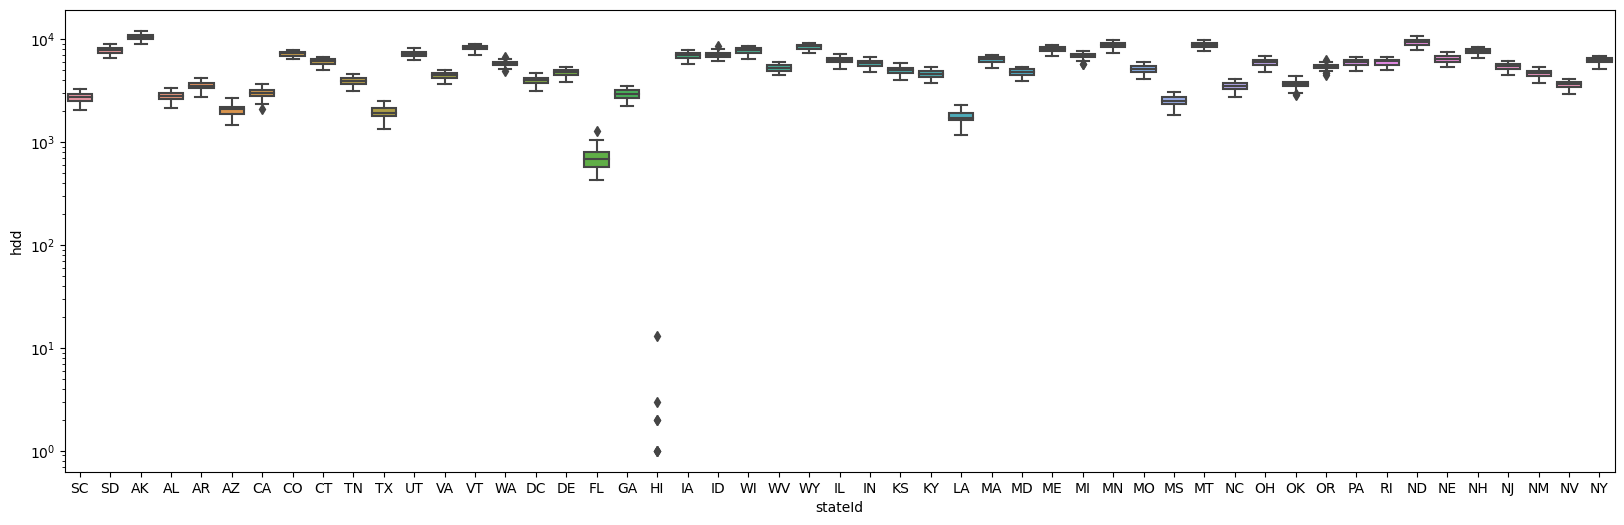

In [50]:
# Quality: visually looking at "outliers" using plots

plt.figure(figsize=(20, 6))  # Width: 15, Height: 6
sns.boxplot(x='stateId', y='hdd', data=df_hdd_states_clean)

plt.yscale('log')  # Use a log scale if values vary widely
plt.show()

It appears that Hawaii is an "outlier" among the other states since it has too few data (missing data?) and much lower hdd values. However, this is expected for a warm tropical state. I will keep Hawaii in the dataframe for the time being and evaluate it's renewable energy and hdd data together.

In [51]:
# Save the cleaned hdd state dataset to a CSV file
df_hdd_states_clean.to_csv("hdd_clean_state_data.csv", index=False)

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [52]:
# All unnecessary variables have already been removed, combine datasets

df_merged = pd.merge(df_re_states_clean, df_hdd_states_clean, on=['year', 'stateId'], how='right')
df_merged.head()

,year,stateId,REPRB,RERCB,RETCB,hdd
0,2022,SC,128184.0,3248.0,143051.0,2502
1,2021,SC,125590.0,2686.0,141820.0,2373
2,2020,SC,128471.0,2652.0,141796.0,2164
3,2019,SC,126976.0,3083.0,143524.0,2336
4,2018,SC,125620.0,2973.0,143746.0,2612


## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [53]:
#Combined Renewable Energy and Heating Degree Day data - saving data
#Optional: store the raw data in your local data store
# Save the raw Energy dataset to a CSV file
df_merged.to_csv("combined_re_hdd_clean_data.csv", index=False)

## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

#### Research Proposal
1. Analyze HDD Trends: Investigate  heating demand (HDD) has changed from 1960 to 2022, to help contextualize renewable energy adoption trends after 1990;
2. Look at correlations between renewable energy production and consumption across the different states for 1990-2022;
3. Project Renewable Energy:
- Use HDD as a predictor to extrapolate how renewable energy production/consumption might have responded to heating demands in the earlier years (1960–1989).
- Speculatively show the potential role of renewables had they been adopted earlier.


*Research question:* Is there a relationship between renewable energy consumption and heating degree days? Can clustering states based on their production-consumption relationship reveal patterns that differentiate energy-resilient states from less-resilient ones?

In [54]:
#Import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

### 1. HDD trend with time

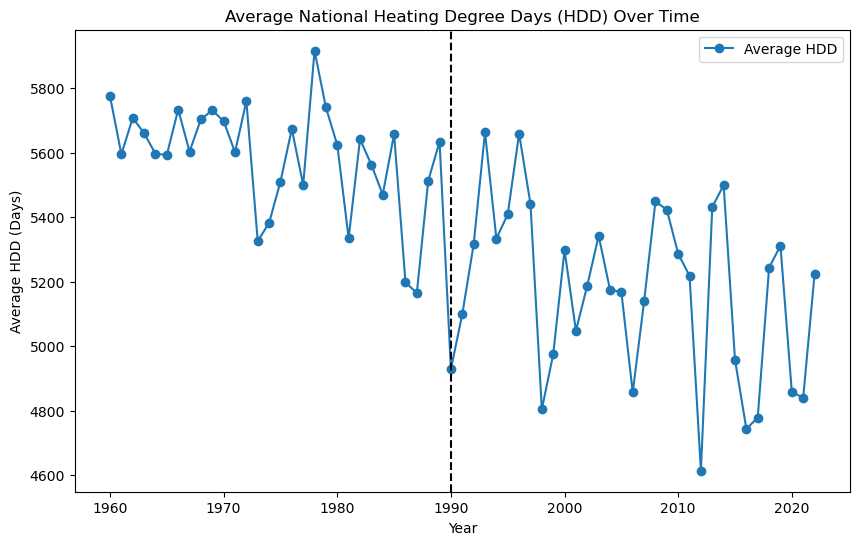

In [55]:
#Visual 1 - Heating demand from 1960 to 2022


# Group HDD data by year to get overall trends
hdd_trends = df_merged.groupby('year')['hdd'].mean().reset_index()

# Plot HDD trends over time
plt.figure(figsize=(10, 6))
plt.plot(hdd_trends['year'], hdd_trends['hdd'], marker='o', linestyle='-', label='Average HDD')
plt.title("Average National Heating Degree Days (HDD) Over Time")
plt.xlabel("Year")
plt.ylabel("Average HDD (Days)")
plt.axvline(x=1990, color='black', linestyle='--')
plt.legend()
plt.show()

As a first step, I looked at the overall national heating data by year, to determine whethere there is a discernible trend. Within the 1960 - 2022 timeframe, mean heating degree days start of fairly constant until ~1970 and then follow a downward trend, possibly as a result of global climate change.

I drew a vertical line at 1990 which is where the renewable data begins. If a correlation between energy production/consumption and HDD exists and making a number of assumptions, it wolud be interesting to try back-projecting energy data between 1990 and 1960.

Representative States: ['HI', 'FL', 'LA', 'NJ', 'OR', 'WA', 'MN', 'ND', 'AK']


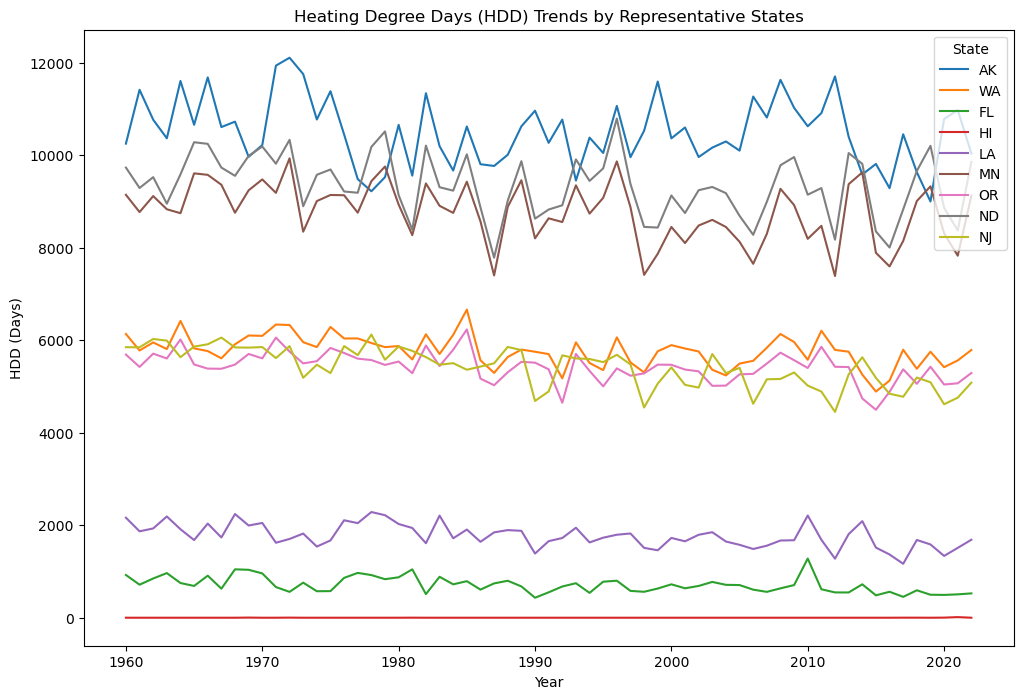

In [56]:
# Calculate average HDD per state
hdd_avg = df_merged.groupby('stateId')['hdd'].mean().sort_values()

# Select states with the lowest, middle, and highest average HDD
low_hdd_states = hdd_avg.head(3).index.tolist()  # 3 states with lowest HDD
middle_hdd_states = hdd_avg.iloc[len(hdd_avg)//2 - 1 : len(hdd_avg)//2 + 2].index.tolist()  # 3 states from the middle
high_hdd_states = hdd_avg.tail(3).index.tolist()  # 3 states with highest HDD

# Combine the states into one list
representative_states = low_hdd_states + middle_hdd_states + high_hdd_states
print("Representative States:", representative_states)

# Filter the DataFrame for these states
hdd_sample = df_merged[df_merged['stateId'].isin(representative_states)]

# Plot the trends
plt.figure(figsize=(12, 8))
sns.lineplot(data=hdd_sample, x='year', y='hdd', hue='stateId')
plt.title("Heating Degree Days (HDD) Trends by Representative States")
plt.xlabel("Year")
plt.ylabel("HDD (Days)")
plt.legend(title="State")
plt.show()

I looked a little more granularly at what HDD data looks like over the same time span for a number of representative states, namely grouping these based on whewher they have low, mean and high HDD values. Not surprisingly, the more tropical/warm states have the lowest (and somewhat flatter/lowest variation) HDD values over time; States with mean HDD values show the strongest overlap, relatively small variation, and a marked decline in HDD with year; In contrast, the colder states have the largest HDD values, also marked by some of the larger year to year variations, likely reflecting climatic variability.

### 2. Correlations Between HDD and Renewable Energy (1990–2022)

Correlation Matrix:
            hdd     REPRB     RERCB     RETCB
hdd    1.000000 -0.140575 -0.150728 -0.252785
REPRB -0.140575  1.000000  0.505792  0.915705
RERCB -0.150728  0.505792  1.000000  0.642293
RETCB -0.252785  0.915705  0.642293  1.000000


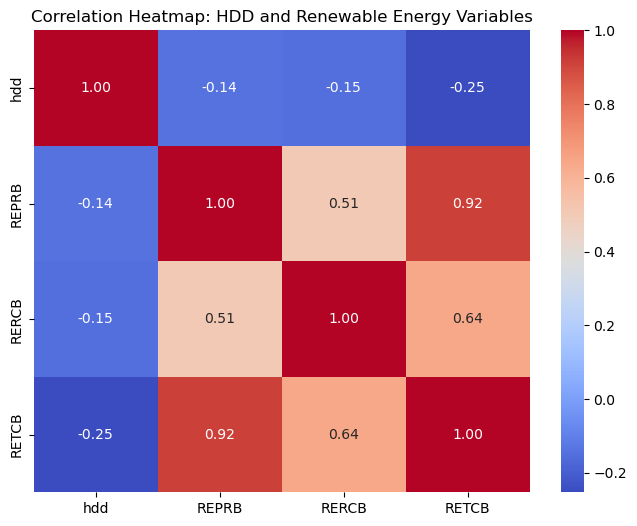

In [57]:
# Filter data for 1990-2022
df_analysis = df_merged[(df_merged['year'] >= 1990) & (df_merged['year'] <= 2022)]

# Correlation matrix
correlations = df_analysis[['hdd', 'REPRB', 'RERCB', 'RETCB']].corr()
print("Correlation Matrix:")
print(correlations)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: HDD and Renewable Energy Variables")
plt.show()

Using a heat map to visually correlate the different variables immediately shows that not only HDD correlates the least with renewable energy production (RETPRB) or consumption (total, RETCB, and residential, RERCB), but these correlations are also negative.

Negative correlations at the national level imply that while HDD go up, renewable energy production/consumption go down. At first this may appear counter-intuitive, but it can be justified if the renewable energy is strongly tied to climate. For example, if one makes the assumption that most renewable energy in the US is derived from solar energy, it makes perfect sense that most is produced during the warm weather and not during the heating degree days, likely snowy, when it would be mostly needed. As a first order observation one may thus use these correlations to make inferences about the source of those energies produced and consumed, which are not included in the dataset.

Not suprising, the strongest (positive) correlation (0.92) is found between total renewable energy production and consumption, whereas only a 0.51 correlation exists between energy production and consumption within the residential sector across the US.

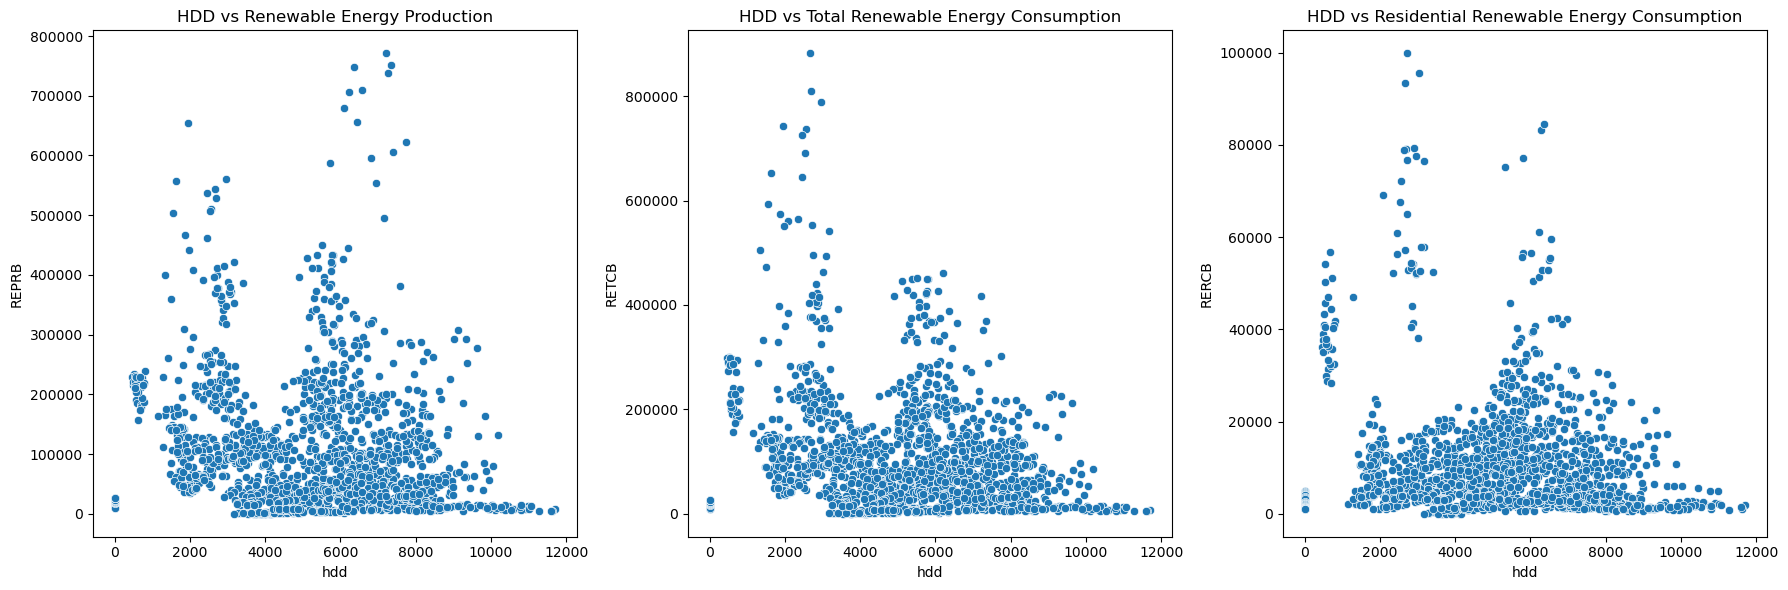

In [58]:
# Scatter plots for HDD vs Energy Variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# HDD vs REPRB
sns.scatterplot(ax=axes[0], x='hdd', y='REPRB', data=df_analysis)
axes[0].set_title("HDD vs Renewable Energy Production")

# HDD vs RETCB
sns.scatterplot(ax=axes[1], x='hdd', y='RETCB', data=df_analysis)
axes[1].set_title("HDD vs Total Renewable Energy Consumption")

# HDD vs RERCB
sns.scatterplot(ax=axes[2], x='hdd', y='RERCB', data=df_analysis)
axes[2].set_title("HDD vs Residential Renewable Energy Consumption")

plt.tight_layout()
plt.show()

I used distinct scatter-plots to visualize data-distribution for total production, total consupmtion and residential consumpion versus HDD. To overall trend is apparent or sub-trend, maybe resulting from variations at the state-level is discernible from these plots.

These may be investigate more thoroughly, but I prefer to move on to analyze energy production versus consumption data.

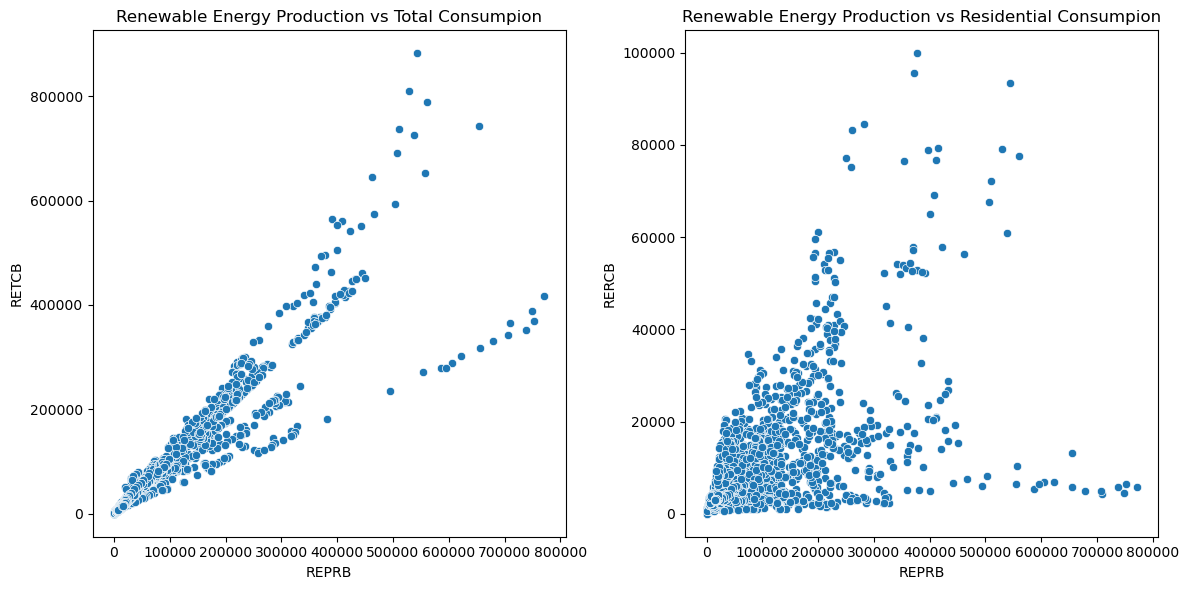

In [59]:
# Scatter plots for Energy Consumption versus Production
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# REPRB vs RETCB
sns.scatterplot(ax=axes[0], x='REPRB', y='RETCB', data=df_analysis)
axes[0].set_title("Renewable Energy Production vs Total Consumpion")

# REPRB vs RETCB
sns.scatterplot(ax=axes[1], x='REPRB', y='RERCB', data=df_analysis)
axes[1].set_title("Renewable Energy Production vs Residential Consumpion")

plt.tight_layout()
plt.show()

Generating scatter plots for total energy consumption versus production and residential energy consumption verus production again yields the strongest correlation for the former. It is also apparent that different sub-trends emerge from the data, likely reflecting variations at the state level.

These will be the focus of the following investigation using machine learning.

### 3. Focus on Total Renewable Energy Production and Total Consumption
#### Rationale:

If REPRB and RETCB are well-correlated, a machine-learning model can predict Total Consumption from Production.

If the data shows different trends/slopes across states, it suggests that state-level policies, infrastructure, or population drive unique relationships. A machine learning model can help identify these patterns.

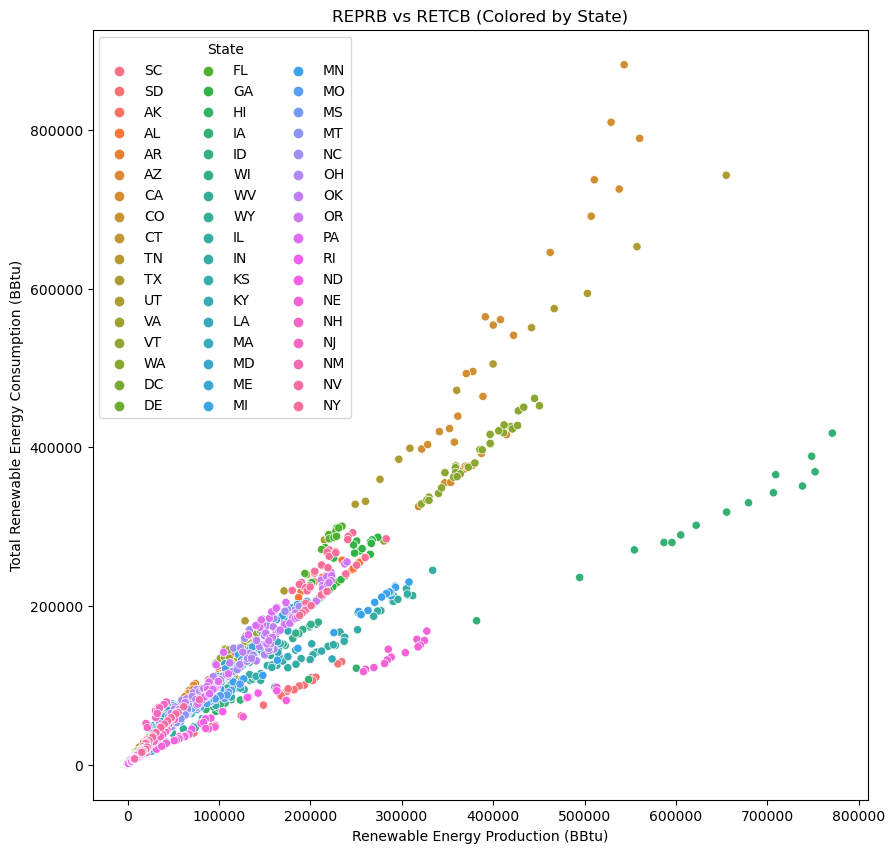

In [60]:
# Focus on REPRB vs RETCB
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_analysis, x='REPRB', y='RETCB', hue='stateId')
plt.title("REPRB vs RETCB (Colored by State)")
plt.xlabel("Renewable Energy Production (BBtu)")
plt.ylabel("Total Renewable Energy Consumption (BBtu)")
plt.legend(title="State", loc="best", ncol=3)
plt.show()

Replotting the total energy consumption versus production and separtaing states by color confirms that different states have different, if not multiple correlations. However, because of the large (51) number of states (plus DC) the similarity among certain color hues, it is difficult to effectively distinguish all state data.

### Test a State-Aware Linear Regression Model

In the following, I start by using a Linear Regression model on all data, with stateId as a categorical feature and fitting the model using with one-hot encoding.

In [61]:
# Filter data for 1990–2022 and drop NaNs
df_model = df_analysis[['REPRB', 'RETCB', 'stateId']].dropna()

# Features (X) and target (y)
X = df_model[['REPRB', 'stateId']]
y = df_model['RETCB']

# One-Hot Encode the 'stateId' column
preprocessor = ColumnTransformer(transformers=[
    ('state', OneHotEncoder(drop='first'), ['stateId'])
], remainder='passthrough')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the pipeline and train the model
model = LinearRegression()
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

model.fit(X_train_encoded, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_encoded)
print("R² Score:", r2_score(y_test, y_pred))

R² Score: 0.9297935513498387


The fit, with an R² score of ~0.93 is reasonable, implying that the model reasonable explains the total renewable energy consumption.

In [62]:
# Get feature names after One-Hot Encoding
encoded_feature_names = preprocessor.named_transformers_['state'].get_feature_names_out(['stateId'])
all_feature_names = list(encoded_feature_names) + ['REPRB']  # Include 'REPRB'

# Extract the coefficients
coefficients = model.coef_.flatten()

# Manually add the baseline state with coefficient 0
baseline_state = 'stateId_' + X['stateId'].unique()[0]  # First state in the original list
all_feature_names = [baseline_state] + all_feature_names
coefficients = [0] + coefficients.tolist()

# Create the DataFrame
coefficients_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Display the coefficients
print("State and REPRB Coefficients:")
print(coefficients_df)

State and REPRB Coefficients:
       Feature    Coefficient
0   stateId_SC       0.000000
1   stateId_AL   22181.498640
2   stateId_AR    3324.005669
3   stateId_AZ    4910.146226
4   stateId_CA  125700.529776
5   stateId_CO   -1276.218146
6   stateId_CT   -1363.455652
7   stateId_DC  -11214.565470
8   stateId_DE   -8658.924845
9   stateId_FL   45432.615042
10  stateId_GA   23279.954159
11  stateId_HI   -6948.283057
12  stateId_IA -151193.092522
13  stateId_ID   -2383.127545
14  stateId_IL  -39319.666369
15  stateId_IN  -27060.854362
16  stateId_KS  -22748.502919
17  stateId_KY    1621.013193
18  stateId_LA    2211.828906
19  stateId_MA    7949.240203
20  stateId_MD    4914.539915
21  stateId_ME    7011.130233
22  stateId_MI   14088.832738
23  stateId_MN  -21283.978380
24  stateId_MO  -10766.771042
25  stateId_MS    -544.740117
26  stateId_MT   -2924.357669
27  stateId_NC   18482.222574
28  stateId_ND  -26902.184418
29  stateId_NE  -82056.716244
30  stateId_NH   -5277.348811
31  stateI

At the state-lever, the individual state coefficients indicate which states deviate most from the baseline trend:
- Positive coefficients indicate higher consumption relative to the baseline;
- Negative coefficients indicate lower consuption relative to the baseline.

With that, significant differences in slopes for certain states might indicate, more efficient renewable energy consumption or policy-driven disparities. Likewise, outliers may be used to identify states with unusually high or low consumption compared to production.

### Visualize the Model Predictions

Plot the model-predicted over actual values for total energy consumption for a direct comparison.

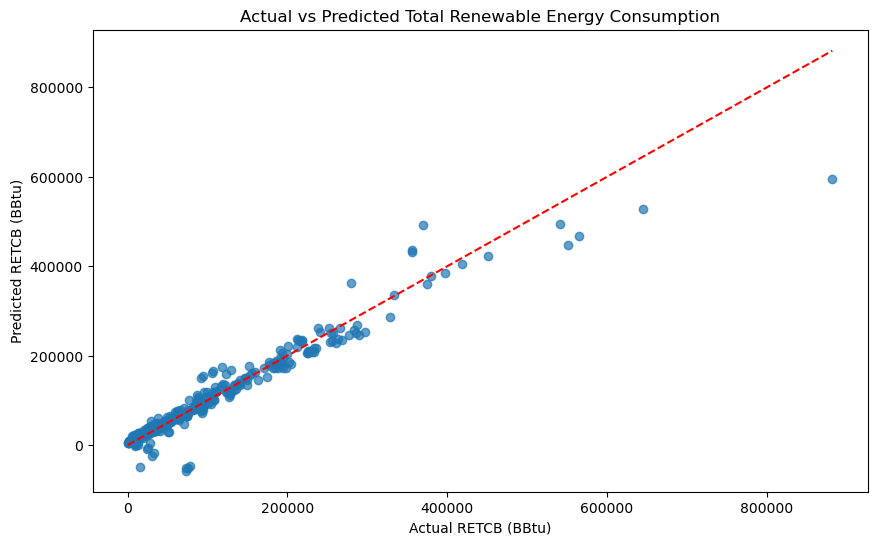

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
plt.title("Actual vs Predicted Total Renewable Energy Consumption")
plt.xlabel("Actual RETCB (BBtu)")
plt.ylabel("Predicted RETCB (BBtu)")
plt.show()

In the plot above, each dot represents a prediction for one observation (test sample):
the x-axis shows the actual values (y_test), while the y-axis shows the predicted values (y_pred).
A red dashed line is plotted to represent perfect agreement: if the model predictions were perfect, all points would lie exactly on the line.

Clearly, the plot shows some scatter with respect to the line, with most points lying either above or below. This is not surprising considering that different states have different consumpions and different state-level slopes had been observed.

Based in this:

### Group States by Slope and Visualize:
For each state I will compute the slope (coefficient) of the linear relationship between REPRB (production) and RETCB (total consumption).
The states will then be clustered by Slope and visualized based on their slope-grouping.

In [64]:
# Filter data for valid rows (1990-2022) and drop NaNs
df_model = df_analysis[['REPRB', 'RETCB', 'stateId']].dropna()

# Compute Slopes for Each State
state_slopes = []

for state in df_model['stateId'].unique():
    state_data = df_model[df_model['stateId'] == state]
    X = state_data[['REPRB']]
    y = state_data['RETCB']
    
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    state_slopes.append({'stateId': state, 'slope': slope})

# Create a DataFrame of slopes
df_slopes = pd.DataFrame(state_slopes)

# Cluster States Based on Slopes (set desired cluster-number)
n_clusters = 9  # Number of groups (adjust as needed)
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
df_slopes['cluster'] = kmeans.fit_predict(df_slopes[['slope']])

print("State Slopes and Clusters:")
print(df_slopes)

# Merge Cluster Information Back into the Original Data
df_clustered = df_model.merge(df_slopes[['stateId', 'cluster']], on='stateId')

State Slopes and Clusters:
   stateId     slope  cluster
0       SC  1.357103        1
1       SD  0.477791        3
2       AK  1.044198        4
3       AL  0.861486        0
4       AR  1.217820        5
5       AZ  1.573732        7
6       CA  2.069369        2
7       CO  1.051688        4
8       CT  0.554804        8
9       TN  1.344667        1
10      TX  1.229475        5
11      UT  1.571465        7
12      VA  1.260740        1
13      VT  1.178914        5
14      WA  1.050573        4
15      DC  0.719667        8
16      DE  2.346053        6
17      FL  1.862320        2
18      GA  1.055234        4
19      HI  0.846414        0
20      IA  0.457575        3
21      ID  1.045715        4
22      WI  0.725334        8
23      WV  1.335198        1
24      WY  0.796888        0
25      IL  0.620200        8
26      IN  0.570078        8
27      KS  0.764030        0
28      KY  1.344396        1
29      LA  0.373385        3
30      MA  0.427055        3
31      MD  0

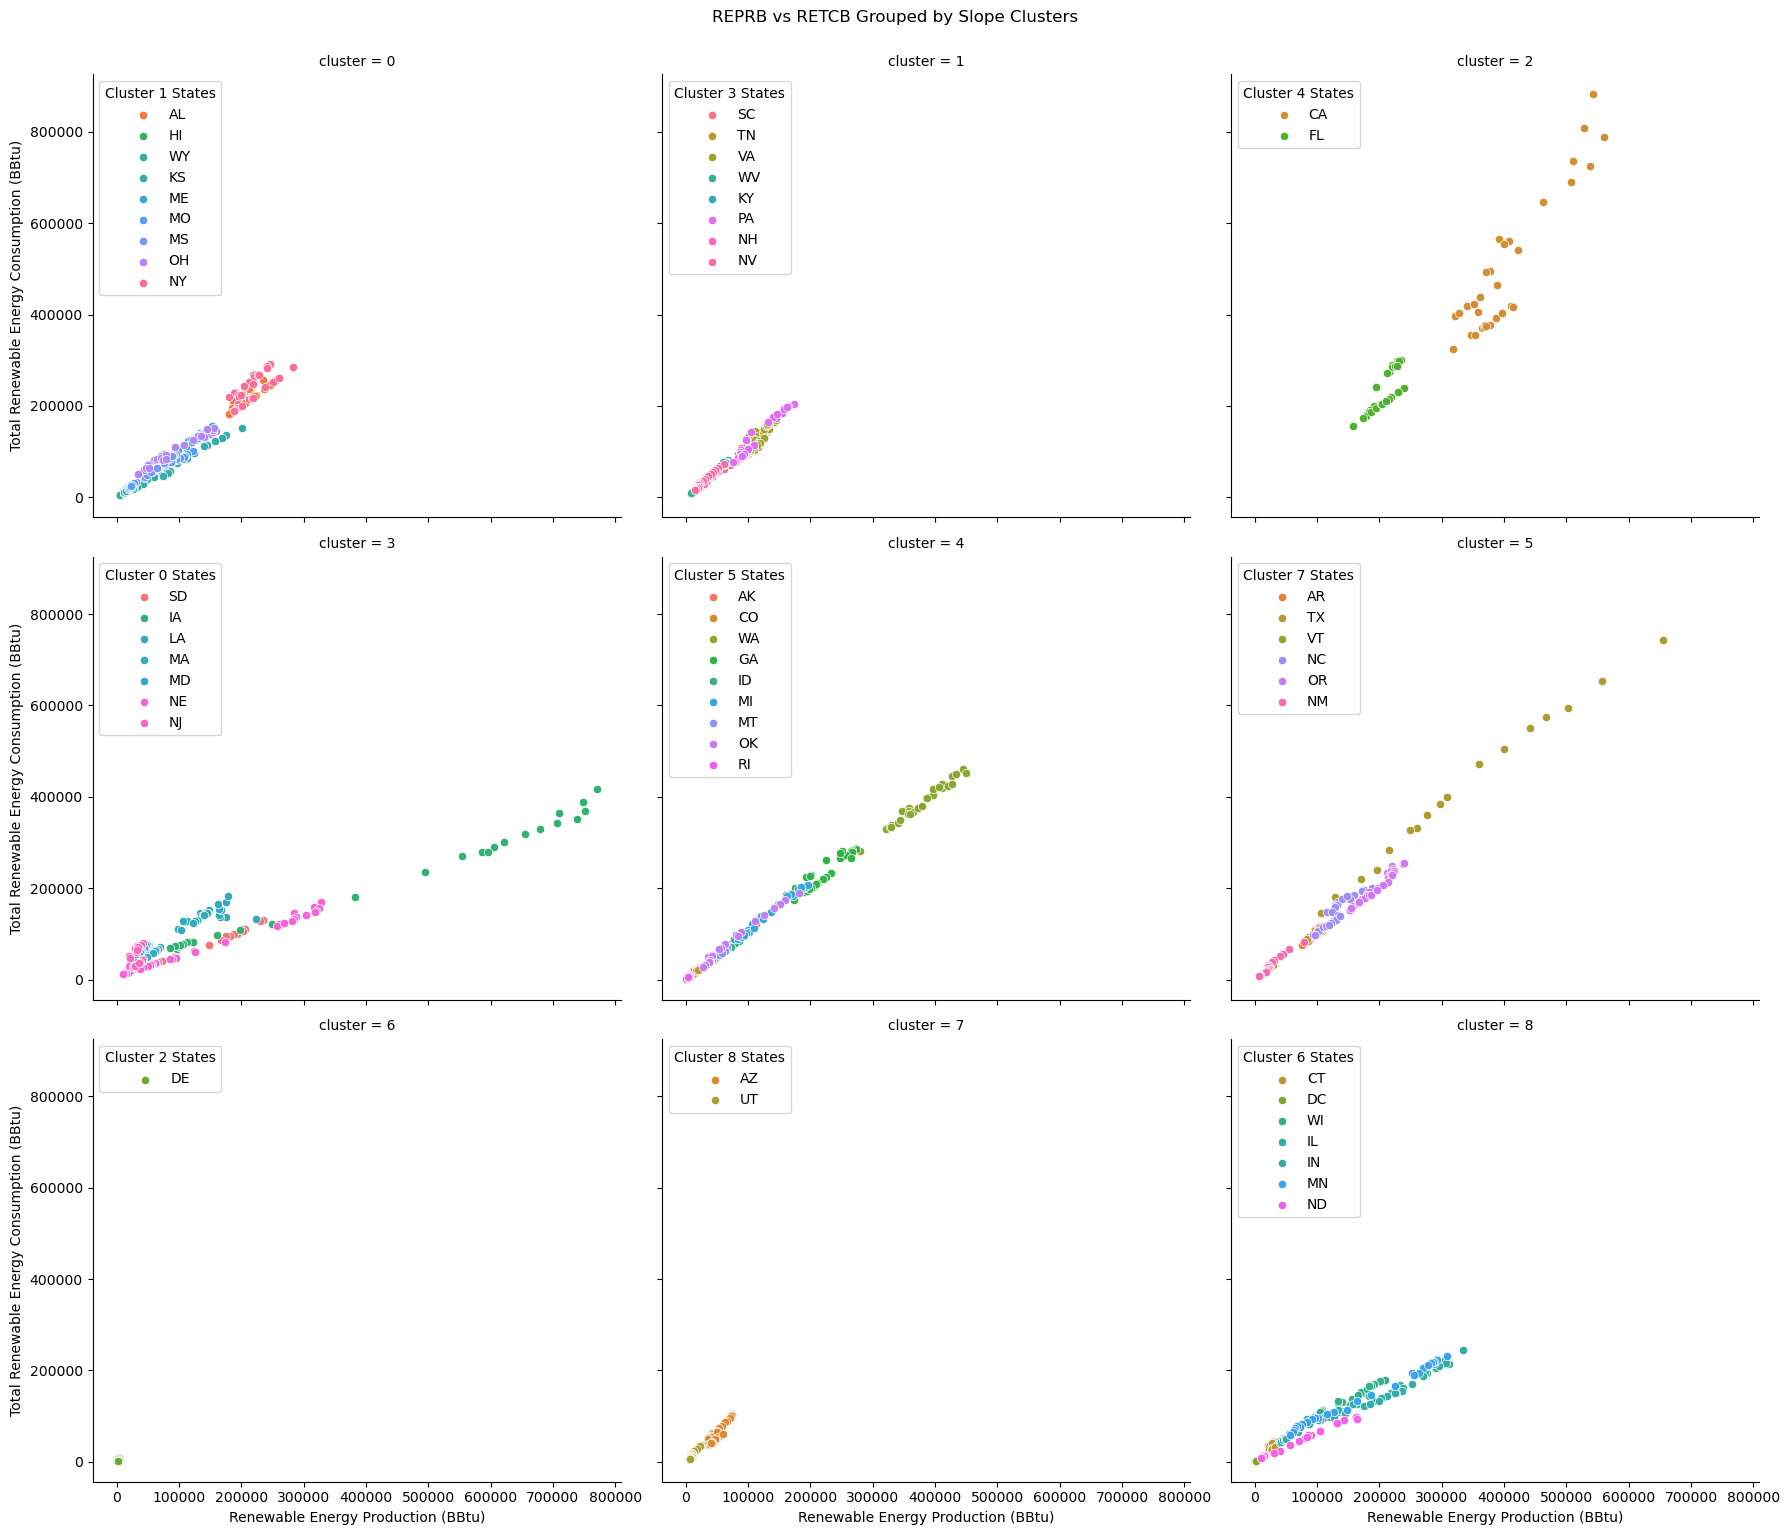

In [65]:
# Plot
# FacetGrid for state-level trends
g = sns.FacetGrid(df_clustered, col='cluster', col_wrap=3, hue='stateId', height=5, aspect=1.2, sharey=True)

# Map scatterplots
g.map(sns.scatterplot, 'REPRB', 'RETCB', alpha=1)

# Add separate legends for each cluster
for ax, cluster_label in zip(g.axes.flat, df_clustered['cluster'].unique()):
    subset = df_clustered[df_clustered['cluster'] == cluster_label]
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title=f"Cluster {cluster_label} States", loc='upper left')

# Add a global title
g.fig.suptitle("REPRB vs RETCB Grouped by Slope Clusters", y=1.02)
g.set_axis_labels("Renewable Energy Production (BBtu)", "Total Renewable Energy Consumption (BBtu)")

plt.show()

Looking for clusterst patterns, I found that a number of 9 clusters better-grouped the data to define clusters with similar REPRB-to-RETCB relationships. Likewise, it allows separating outliers, like the one state (Delaware) with only one data point (cluster 6), statez like Arizona and Utah with fewer than most data (cluster 6), or states with data defining multiple slopes, like California and Florida in cluster 2. The latter in particular may indicate changes in state policies regarding renewable energy, or, for large states, different geographical distinctions (urban versus rural counties, warmer/colder regions...).

Comparing the slopes in the different subplots allows understand state-level variations in renewable energy production and consumption efficiency. While variations exist, including in the number of data by state, but also in slope and scatter, it appears that a dominant similar trend exists, with some cluster exhibiting striningly lower slopes, as is the case for clusters 3 and 8.


3. Predictive Power: The model can predict RETCB (consumption) for states or years with missing data, allowing for cleaner analysis.

*Answer to research question:*  **Is there a relationship between renewable energy consumption and heating degree days?**
No, no strong relationship was observed between renewable energy consumption and heating degree days, which may plainily indicate that there isn't a strong correlation, or that the dominant renewable energy source does not, or as we have seen, negatively correlates with daily temperature. A better breakdown of energy sources would be very interesting: in particular, an renewable energy like geothermal would be very interesting to compare with daily temperatures, but unfortunately not many data are available there.

**Can clustering states based on their production-consumption relationship reveal patterns that differentiate energy-resilient states from less-resilient ones?**
Yes, clusters of states with high slopes indicate large consumption of renewable energy. On the other hand, small slopes may indicate large renewable energy production versus consuptions, which could make these states exporters of renewable energy.

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:* After having analyised these daily temperature and renewable energy data somewhat coarsely, there is much more one could do more granularly.
First of all, one could look more in detail, particularly at the state level at the correlation between HDD and the energy production/consuption data, so that while poor and negative correlations exist at the national level, with no sub-trend being immediately apparent, more revealing correlations may appear for isolated states, particularly depending on specific energy types for which I do not have data.

Secondly, funther investigating renewable energy production/consumption, it would be very interesting to look at specific state data, particularly if energy data type were available, and run state-specific models: here, a good model, based on states with many useful data, would be able to predict consumptions for comparable states or years with missing data, as is the case for Delaware, for example.